Step 1: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)

Step 2: Load and Clean the Data

In [12]:
obesity = pd.read_csv("obesity.csv")

print(obesity.shape)
print(obesity.dtypes)
print(obesity.head())

print(obesity.describe())

print(obesity.describe(include=['object']))

(2111, 17)
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.

Step 3: Plot Histograms and Bar Charts

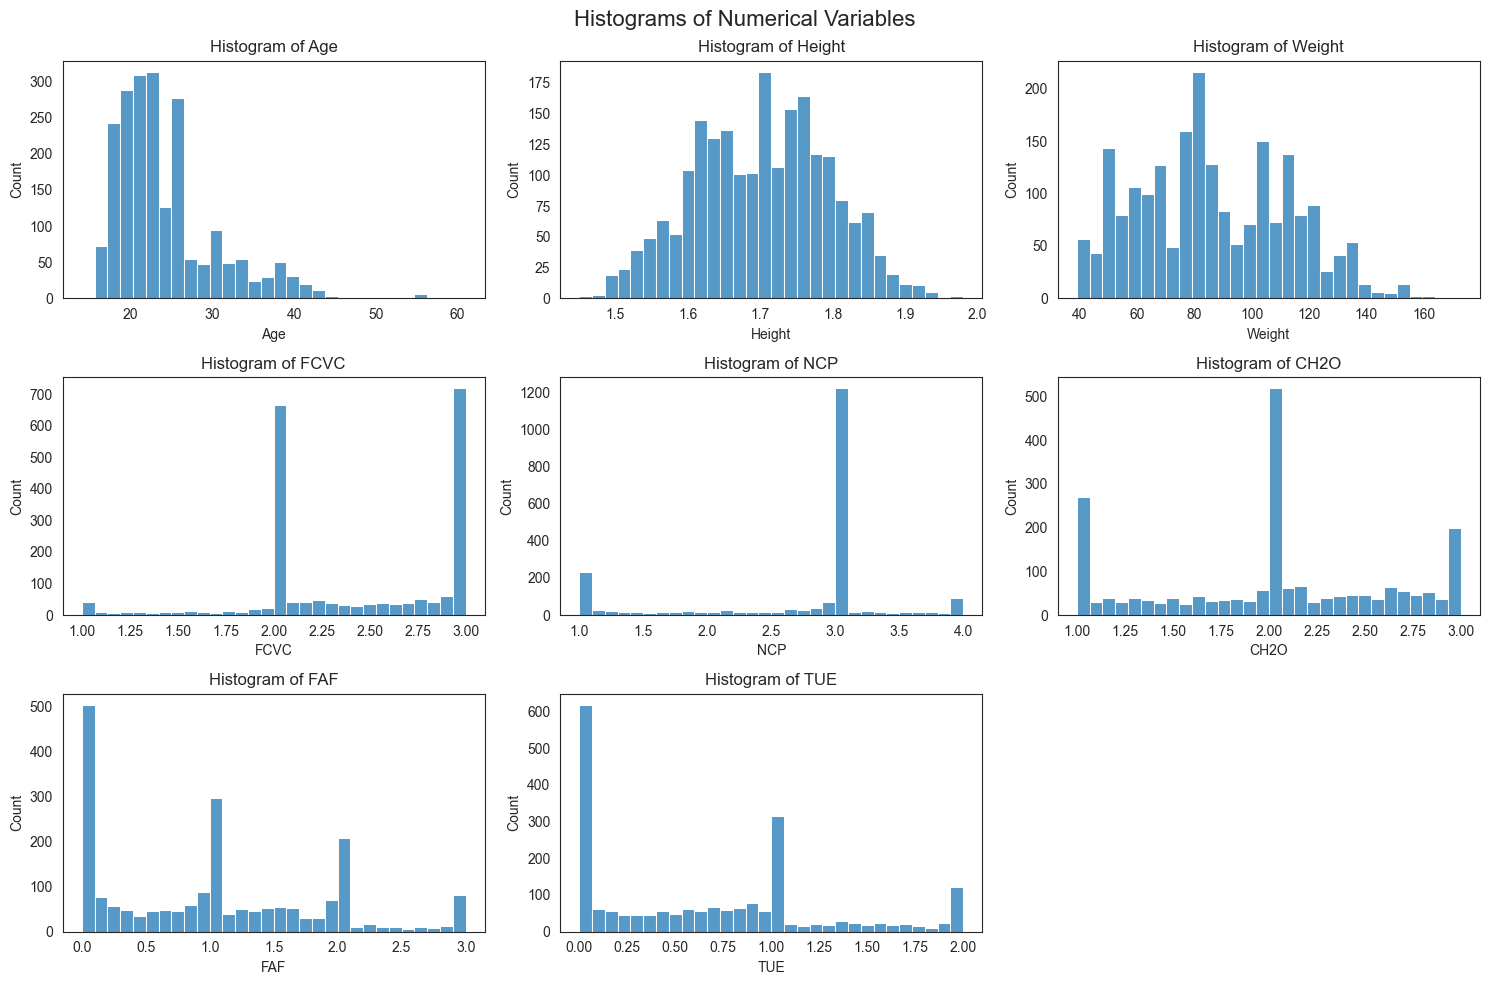

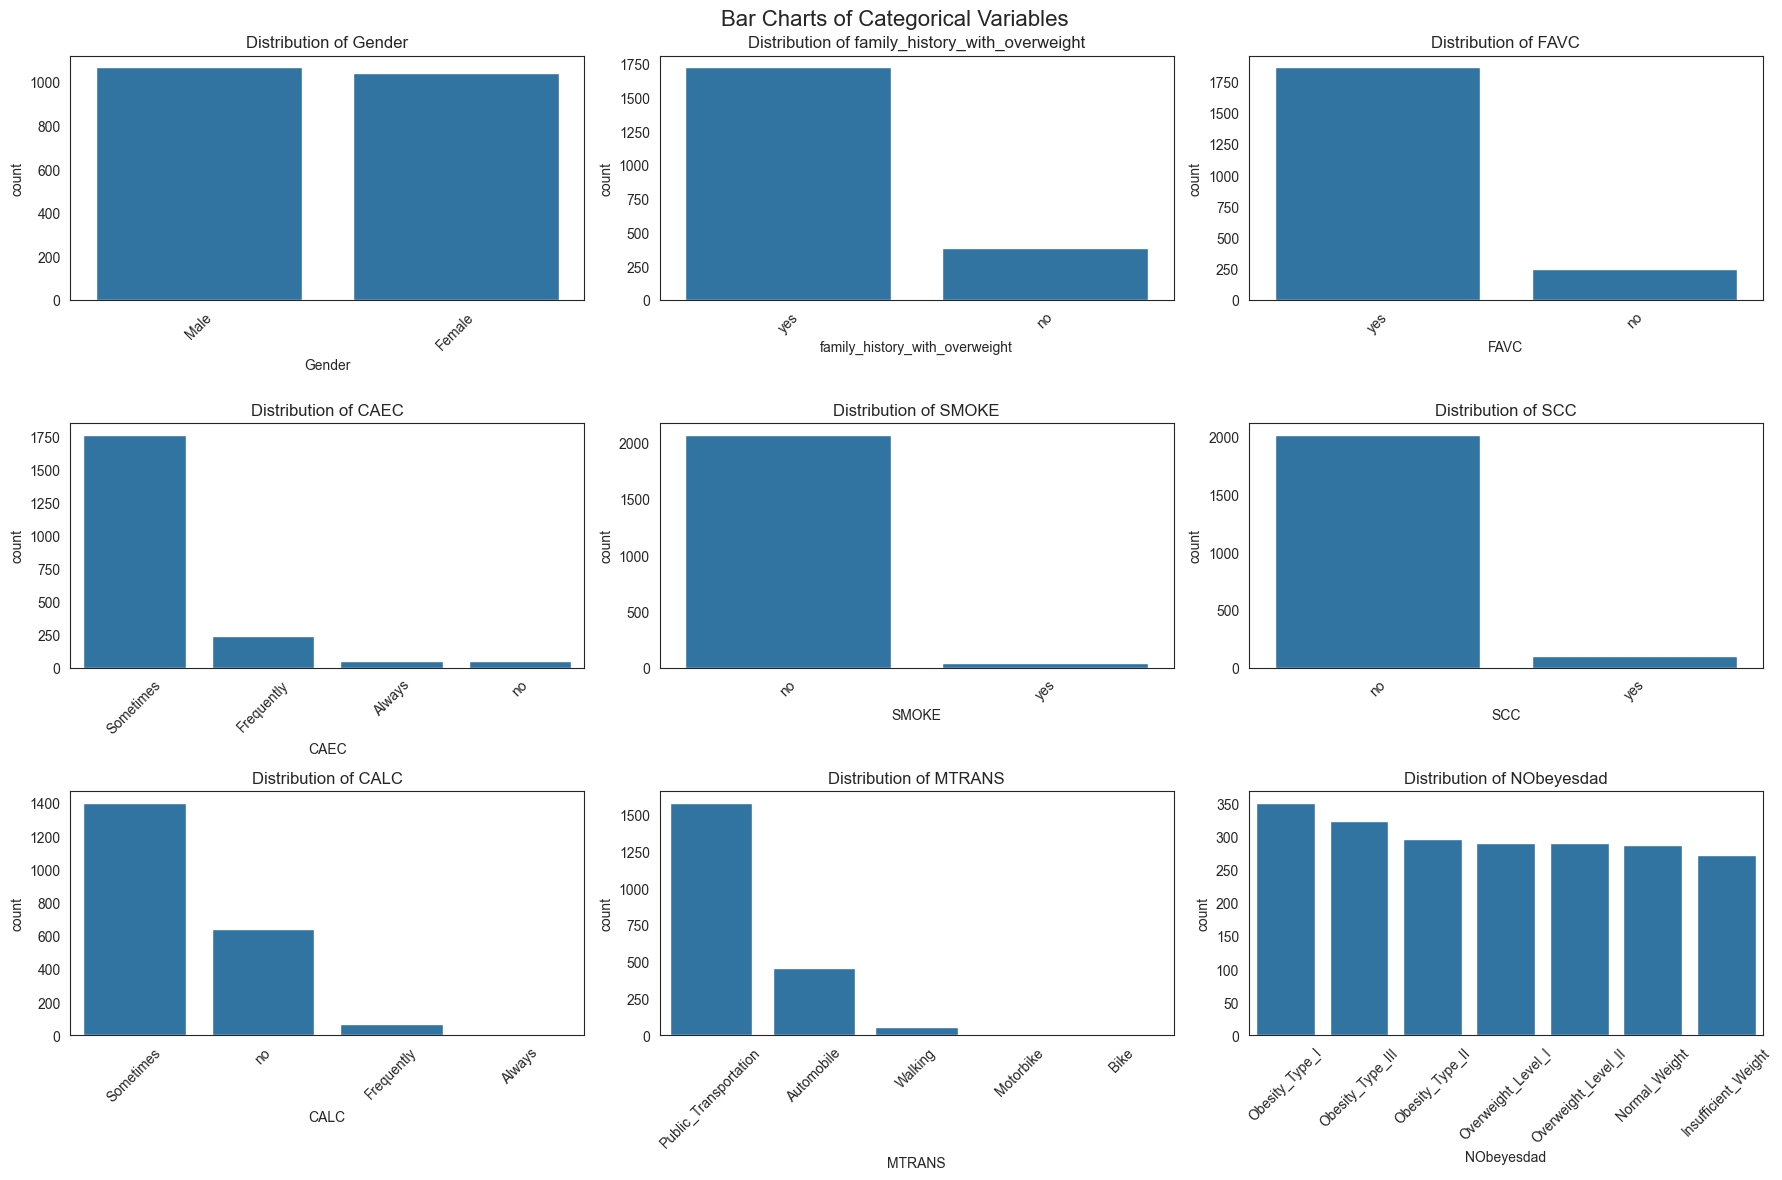

In [13]:
numerical_cols = obesity.select_dtypes(include=['float64', 'int64']).columns

sns.set_style("white")

numerical_cols = obesity.select_dtypes(include=['float64', 'int64']).columns
n = len(numerical_cols)

fig, axes = plt.subplots(nrows=(n // 3 + 1), ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data=obesity, x=col, kde=False, bins=30, ax=axes[i])
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_ylabel("Count")

for j in range(len(numerical_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Histograms of Numerical Variables", fontsize=16)
plt.tight_layout()
plt.savefig("Histograms.png")
plt.show()

categorical_cols = obesity.select_dtypes(include='object').columns
n = len(categorical_cols)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=obesity, x=col, order=obesity[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)

for i in range(len(categorical_cols), len(axes)):
    axes[i].set_visible(False)

plt.suptitle("Bar Charts of Categorical Variables", fontsize=16)
plt.tight_layout()
plt.savefig("BarCharts.png")
plt.show()

Step 4: Collapse Response Variable

ObeseBinary
0    1139
1     972
Name: count, dtype: int64


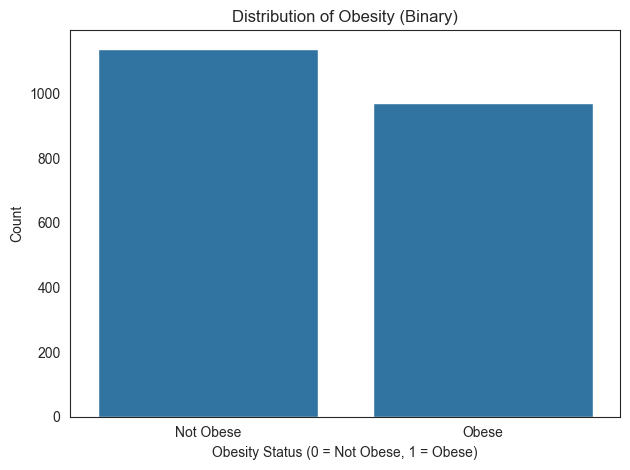

In [14]:
obese_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 0,
    'Overweight_Level_I': 0,
    'Overweight_Level_II': 0,
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1
}

obesity['ObeseBinary'] = obesity['NObeyesdad'].map(obese_map)

print(obesity['ObeseBinary'].value_counts())

obesity.drop(columns=['NObeyesdad'], inplace=True)

sns.countplot(data=obesity, x='ObeseBinary')
plt.title("Distribution of Obesity (Binary)")
plt.xlabel("Obesity Status (0 = Not Obese, 1 = Obese)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Obese', 'Obese'])
plt.tight_layout()
plt.savefig("ResponseDist")
plt.show()

Step 5: Map Categorical Variables

In [15]:
binary_map = {
    'Gender': {'Male': 0, 'Female': 1},
    'family_history_with_overweight': {'no': 0, 'yes': 1},
    'FAVC': {'no': 0, 'yes': 1},
    'SMOKE': {'no': 0, 'yes': 1},
    'SCC': {'no': 0, 'yes': 1}
}

ordinal_map = {
    'CAEC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
    'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
}

obesity.replace(binary_map, inplace=True)
obesity.replace(ordinal_map, inplace=True)

mtrans_map = {
    'Public_Transportation': 0,
    'Automobile': 1,
    'Walking': 2,
    'Motorbike': 3,
    'Bike': 4
}
obesity['MTRANS'] = obesity['MTRANS'].map(mtrans_map)

C:\Users\adely\AppData\Local\Temp\ipykernel_23624\2623299550.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obesity.replace(binary_map, inplace=True)
C:\Users\adely\AppData\Local\Temp\ipykernel_23624\2623299550.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obesity.replace(ordinal_map, inplace=True)


Step 6: Calculate Correlation Matrix 

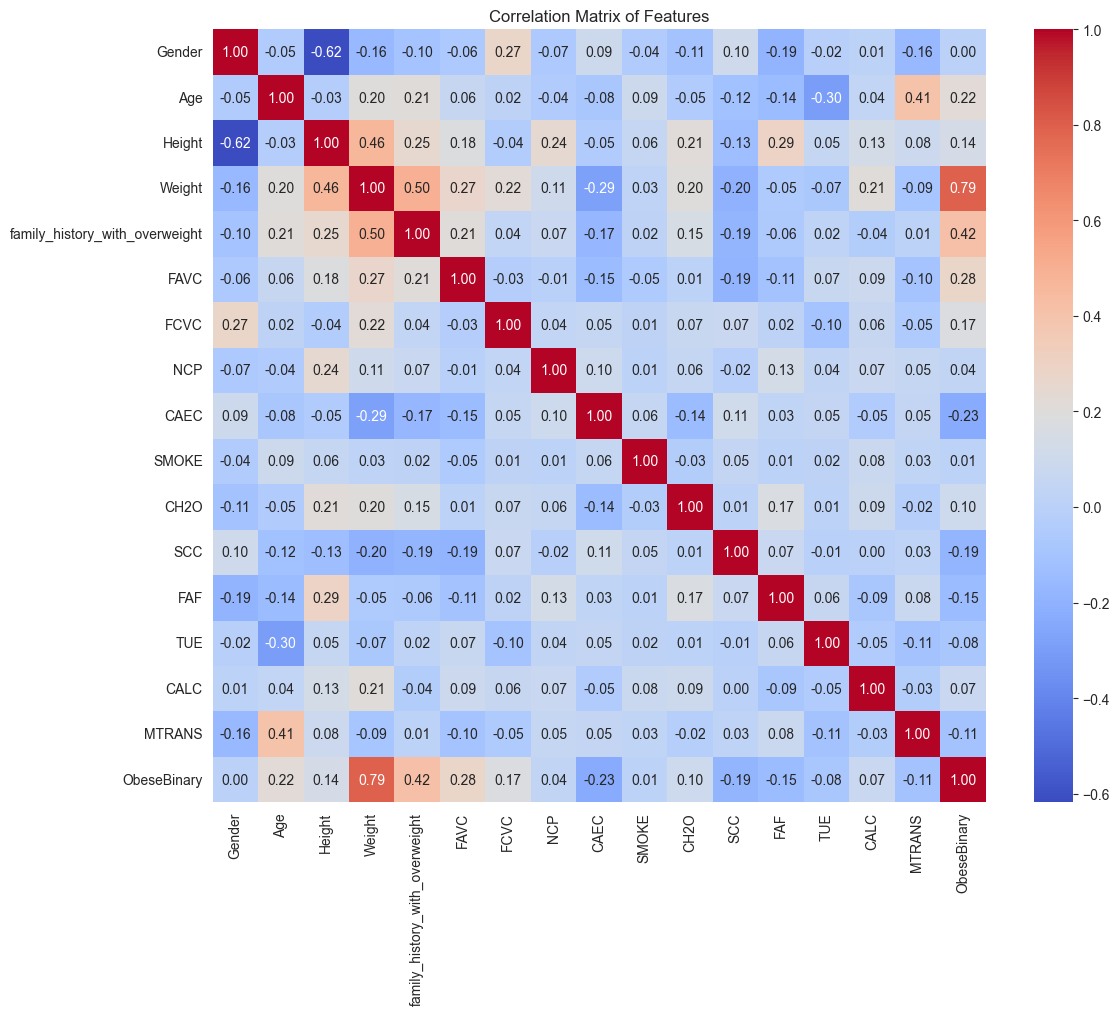

In [16]:
corr_matrix = obesity.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.savefig("CorrelationHeat")
plt.show()

Step 7: Split Data into Training and Validation Sets, Fit Baseline Models

In [7]:
seed = np.random.seed(16)

X = obesity.drop(columns=['ObeseBinary'])  
y = obesity['ObeseBinary']                 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(random_state=seed, class_weight='balanced', max_iter=5000),
    "Classification Tree": DecisionTreeClassifier(random_state=seed, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=seed),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=seed)
}


trained_models = {}

for name, model in models.items():
    print(f"Training: {name}")

    if name in ["k-NN", "LDA", "QDA", "Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)

    trained_models[name] = model


Training: k-NN
Training: LDA
Training: QDA
Training: Logistic Regression
Training: Classification Tree
Training: Random Forest
Training: Gradient Boosting
Training: SVM


Step 8: Tune Hyperparameters via Optuna with 5 Fold Cross Validation

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def tune_knn():
    def objective(trial):
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int("n_neighbors", 3, 25)
        )
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="k-NN")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_lda():
    def objective(trial):
        model = LinearDiscriminantAnalysis()
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="LDA")
    study.optimize(objective, n_trials=1)
    return {}, study.best_value

def tune_qda():
    def objective(trial):
        model = QuadraticDiscriminantAnalysis()
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="QDA")
    study.optimize(objective, n_trials=1)
    return {}, study.best_value

def tune_logistic_regression():
    def objective(trial):
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
        solver = "saga"
        C = trial.suggest_float("C", 1e-3, 10.0, log=True)

        kwargs = {
            "penalty": penalty,
            "solver": solver,
            "C": C,
            "max_iter": 5000,
            "class_weight": 'balanced',
            "random_state": seed
        }

        if penalty == "elasticnet":
            kwargs["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

        model = LogisticRegression(**kwargs)
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()

    study = optuna.create_study(direction="maximize", study_name="LogisticRegression")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_decision_tree():
    def objective(trial):
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="DecisionTree")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_random_forest():
    def objective(trial):
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 200),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="RandomForest")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_gradient_boosting():
    def objective(trial):
        model = GradientBoostingClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 200),
            learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            random_state=seed
        )
        return cross_val_score(model, X_train, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="GradientBoosting")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

def tune_svm():
    def objective(trial):
        model = SVC(
            C=trial.suggest_float("C", 1e-3, 10.0, log=True),
            gamma=trial.suggest_float("gamma", 1e-4, 1e-1, log=True),
            kernel="rbf",
            probability=True,
            class_weight='balanced',
            random_state=seed
        )
        return cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize", study_name="SVM")
    study.optimize(objective, n_trials=50)
    return study.best_params, study.best_value

print("Tuning k-NN...")
knn_params, knn_score = tune_knn()

print("Evaluating LDA...")
lda_params, lda_score = tune_lda()

print("Evaluating QDA...")
qda_params, qda_score = tune_qda()

print("Tuning Logistic Regression...")
logreg_params, logreg_score = tune_logistic_regression()

print("Tuning Decision Tree...")
tree_params, tree_score = tune_decision_tree()

print("Tuning Random Forest...")
rf_params, rf_score = tune_random_forest()

print("Tuning Gradient Boosting...")
gb_params, gb_score = tune_gradient_boosting()

print("Tuning SVM...")
svm_params, svm_score = tune_svm()

print("\n Summary:")
print("k-NN:", knn_params, f"Balanced Accuracy: {knn_score:.4f}")
print("LDA:", f"Balanced Accuracy: {lda_score:.4f}")
print("QDA:", f"Balanced Accuracy: {qda_score:.4f}")
print("Logistic Regression:", logreg_params, f"Balanced Accuracy: {logreg_score:.4f}")
print("Decision Tree:", tree_params, f"Balanced Accuracy: {tree_score:.4f}")
print("Random Forest:", rf_params, f"Balanced Accuracy: {rf_score:.4f}")
print("Gradient Boosting:", gb_params, f"Balanced Accuracy: {gb_score:.4f}")
print("SVM:", svm_params, f"Balanced Accuracy: {svm_score:.4f}")


[I 2025-04-18 20:57:17,215] A new study created in memory with name: k-NN
[I 2025-04-18 20:57:17,258] Trial 0 finished with value: 0.9252936698415283 and parameters: {'n_neighbors': 16}. Best is trial 0 with value: 0.9252936698415283.
[I 2025-04-18 20:57:17,285] Trial 1 finished with value: 0.9299752732724705 and parameters: {'n_neighbors': 16}. Best is trial 1 with value: 0.9299752732724705.
[I 2025-04-18 20:57:17,313] Trial 2 finished with value: 0.9325292352632385 and parameters: {'n_neighbors': 16}. Best is trial 2 with value: 0.9325292352632385.
[I 2025-04-18 20:57:17,337] Trial 3 finished with value: 0.9266098813930649 and parameters: {'n_neighbors': 16}. Best is trial 2 with value: 0.9325292352632385.
[I 2025-04-18 20:57:17,364] Trial 4 finished with value: 0.9244271496175251 and parameters: {'n_neighbors': 13}. Best is trial 2 with value: 0.9325292352632385.
[I 2025-04-18 20:57:17,390] Trial 5 finished with value: 0.9054819823222784 and parameters: {'n_neighbors': 23}. Best is 

Tuning k-NN...


[I 2025-04-18 20:57:17,442] Trial 7 finished with value: 0.9403071131230835 and parameters: {'n_neighbors': 6}. Best is trial 7 with value: 0.9403071131230835.
[I 2025-04-18 20:57:17,473] Trial 8 finished with value: 0.909265762441331 and parameters: {'n_neighbors': 21}. Best is trial 7 with value: 0.9403071131230835.
[I 2025-04-18 20:57:17,497] Trial 9 finished with value: 0.930378397382628 and parameters: {'n_neighbors': 9}. Best is trial 7 with value: 0.9403071131230835.
[I 2025-04-18 20:57:17,525] Trial 10 finished with value: 0.9446430944342102 and parameters: {'n_neighbors': 3}. Best is trial 10 with value: 0.9446430944342102.
[I 2025-04-18 20:57:17,550] Trial 11 finished with value: 0.941132025034722 and parameters: {'n_neighbors': 3}. Best is trial 10 with value: 0.9446430944342102.
[I 2025-04-18 20:57:17,581] Trial 12 finished with value: 0.9460043138599458 and parameters: {'n_neighbors': 3}. Best is trial 12 with value: 0.9460043138599458.
[I 2025-04-18 20:57:17,610] Trial 13

Evaluating LDA...
Evaluating QDA...
Tuning Logistic Regression...


[I 2025-04-18 20:57:21,700] Trial 1 finished with value: 0.9957751388396551 and parameters: {'penalty': 'l1', 'C': 4.781681694468808}. Best is trial 1 with value: 0.9957751388396551.
[I 2025-04-18 20:57:22,400] Trial 2 finished with value: 0.9963245893891056 and parameters: {'penalty': 'l1', 'C': 0.5236105038688956}. Best is trial 2 with value: 0.9963245893891056.
[I 2025-04-18 20:57:22,439] Trial 3 finished with value: 0.8796156558055024 and parameters: {'penalty': 'l2', 'C': 0.002071004721188629}. Best is trial 2 with value: 0.9963245893891056.
[I 2025-04-18 20:57:22,477] Trial 4 finished with value: 0.9181827647057684 and parameters: {'penalty': 'l2', 'C': 0.006133197359516328}. Best is trial 2 with value: 0.9963245893891056.
[I 2025-04-18 20:57:22,501] Trial 5 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.0010553436753532252}. Best is trial 2 with value: 0.9963245893891056.
[I 2025-04-18 20:57:22,548] Trial 6 finished with value: 0.98230566806717 and parameters:

Tuning Decision Tree...


[I 2025-04-18 20:57:40,202] Trial 4 finished with value: 0.9863387687581235 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9895559068113272.
[I 2025-04-18 20:57:40,256] Trial 5 finished with value: 0.9845132718506594 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9895559068113272.
[I 2025-04-18 20:57:40,313] Trial 6 finished with value: 0.9846810126239 and parameters: {'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9895559068113272.
[I 2025-04-18 20:57:40,362] Trial 7 finished with value: 0.9870649674668712 and parameters: {'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9895559068113272.
[I 2025-04-18 20:57:40,414] Trial 8 finished with value: 0.989463198532474 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with v

Tuning Random Forest...


[I 2025-04-18 20:57:43,398] Trial 0 finished with value: 0.9669675327316787 and parameters: {'n_estimators': 53, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9669675327316787.
[I 2025-04-18 20:57:45,070] Trial 1 finished with value: 0.98698166367389 and parameters: {'n_estimators': 154, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.98698166367389.
[I 2025-04-18 20:57:46,429] Trial 2 finished with value: 0.9799858690577887 and parameters: {'n_estimators': 130, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.98698166367389.
[I 2025-04-18 20:57:47,677] Trial 3 finished with value: 0.976353287114789 and parameters: {'n_estimators': 128, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.98698166367389.
[I 2025-04-18 20:57:48,802] Trial 4 finished with value: 0.9070691999697816 and parameters: {'n_estimato

Tuning Gradient Boosting...


[I 2025-04-18 20:58:58,798] Trial 0 finished with value: 0.9577431170979558 and parameters: {'n_estimators': 57, 'learning_rate': 0.0014300615870472785, 'max_depth': 5, 'subsample': 0.765833036871995}. Best is trial 0 with value: 0.9577431170979558.
[I 2025-04-18 20:59:00,288] Trial 1 finished with value: 0.9917518397343887 and parameters: {'n_estimators': 57, 'learning_rate': 0.02180066676076435, 'max_depth': 6, 'subsample': 0.5834867832461268}. Best is trial 1 with value: 0.9917518397343887.
[I 2025-04-18 20:59:06,480] Trial 2 finished with value: 0.9822103544261133 and parameters: {'n_estimators': 171, 'learning_rate': 0.0010344722423701771, 'max_depth': 10, 'subsample': 0.9790199630947116}. Best is trial 1 with value: 0.9917518397343887.
[I 2025-04-18 20:59:07,635] Trial 3 finished with value: 0.9898092177521051 and parameters: {'n_estimators': 53, 'learning_rate': 0.018326024560905936, 'max_depth': 5, 'subsample': 0.5701654005521417}. Best is trial 1 with value: 0.9917518397343887

Tuning SVM...


[I 2025-04-18 21:01:35,962] Trial 0 finished with value: 0.5 and parameters: {'C': 0.00409760271275307, 'gamma': 0.0002943428865572575}. Best is trial 0 with value: 0.5.
[I 2025-04-18 21:01:37,584] Trial 1 finished with value: 0.8981529144220841 and parameters: {'C': 1.947798276808779, 'gamma': 0.00038188835246198715}. Best is trial 1 with value: 0.8981529144220841.
[I 2025-04-18 21:01:39,826] Trial 2 finished with value: 0.5 and parameters: {'C': 0.003947401937930271, 'gamma': 0.02350596668356082}. Best is trial 1 with value: 0.8981529144220841.
[I 2025-04-18 21:01:41,365] Trial 3 finished with value: 0.9007470997185434 and parameters: {'C': 0.836200720376278, 'gamma': 0.0010199996929029327}. Best is trial 3 with value: 0.9007470997185434.
[I 2025-04-18 21:01:43,528] Trial 4 finished with value: 0.8073908411348919 and parameters: {'C': 1.1317842700202576, 'gamma': 0.00015898001396386522}. Best is trial 3 with value: 0.9007470997185434.
[I 2025-04-18 21:01:45,811] Trial 5 finished with


 Summary:
k-NN: {'n_neighbors': 4} Balanced Accuracy: 0.9510
LDA: Balanced Accuracy: 0.9698
QDA: Balanced Accuracy: 0.8696
Logistic Regression: {'penalty': 'l1', 'C': 0.12774129735794823} Balanced Accuracy: 0.9982
Decision Tree: {'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7} Balanced Accuracy: 0.9911
Random Forest: {'n_estimators': 146, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1} Balanced Accuracy: 0.9928
Gradient Boosting: {'n_estimators': 64, 'learning_rate': 0.20579834825926702, 'max_depth': 4, 'subsample': 0.6816110431580108} Balanced Accuracy: 0.9953
SVM: {'C': 9.43187244567149, 'gamma': 0.007931920498235212} Balanced Accuracy: 0.9921


Step 9: Evaluate Models on Test Data

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"{model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 40)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Not Obese (0)", "Obese (1)"],
                yticklabels=["Not Obese (0)", "Obese (1)"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_confusion.png", dpi=300)
    plt.close()

knn_model = KNeighborsClassifier(**knn_params)
knn_model.fit(X_train_scaled, y_train)
evaluate_model(knn_model, X_test_scaled, y_test, "k-NN")

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_scaled, y_train)
evaluate_model(lda_model, X_test_scaled, y_test, "LDA")

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train_scaled, y_train)
evaluate_model(qda_model, X_test_scaled, y_test, "QDA")

log_model = LogisticRegression(**logreg_params, max_iter=5000, solver='saga', class_weight='balanced', random_state=seed)
log_model.fit(X_train_scaled, y_train)
evaluate_model(log_model, X_test_scaled, y_test, "Logistic Regression")

tree_model = DecisionTreeClassifier(**tree_params, class_weight='balanced', random_state=seed)
tree_model.fit(X_train, y_train)
evaluate_model(tree_model, X_test, y_test, "Decision Tree")

rf_model = RandomForestClassifier(**rf_params, class_weight='balanced', random_state=seed)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

gb_model = GradientBoostingClassifier(**gb_params, random_state=seed)
gb_model.fit(X_train, y_train)
evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")

svm_model = SVC(**svm_params, probability=True, class_weight='balanced', random_state=seed)
svm_model.fit(X_train_scaled, y_train)
evaluate_model(svm_model, X_test_scaled, y_test, "SVM")


k-NN:
Accuracy: 0.9550827423167849
Balanced Accuracy: 0.9546221322537112
Precision: 0.9536082474226805
Recall: 0.9487179487179487
F1 Score: 0.9511568123393316
ROC AUC: 0.9837719298245615
Confusion Matrix:
 [[219   9]
 [ 10 185]]
----------------------------------------
LDA:
Accuracy: 0.9763593380614657
Balanced Accuracy: 0.9765856950067476
Precision: 0.9695431472081218
Recall: 0.9794871794871794
F1 Score: 0.9744897959183674
ROC AUC: 0.9984030589293746
Confusion Matrix:
 [[222   6]
 [  4 191]]
----------------------------------------
QDA:
Accuracy: 0.8983451536643026
Balanced Accuracy: 0.902361673414305
Precision: 0.8454545454545455
Recall: 0.9538461538461539
F1 Score: 0.8963855421686747
ROC AUC: 0.975596041385515
Confusion Matrix:
 [[194  34]
 [  9 186]]
----------------------------------------
Logistic Regression:
Accuracy: 0.9976359338061466
Balanced Accuracy: 0.9978070175438596
Precision: 0.9948979591836735
Recall: 1.0
F1 Score: 0.9974424552429667
ROC AUC: 1.0
Confusion Matrix:
 [[2

Step 10: Permutation Feature Importance

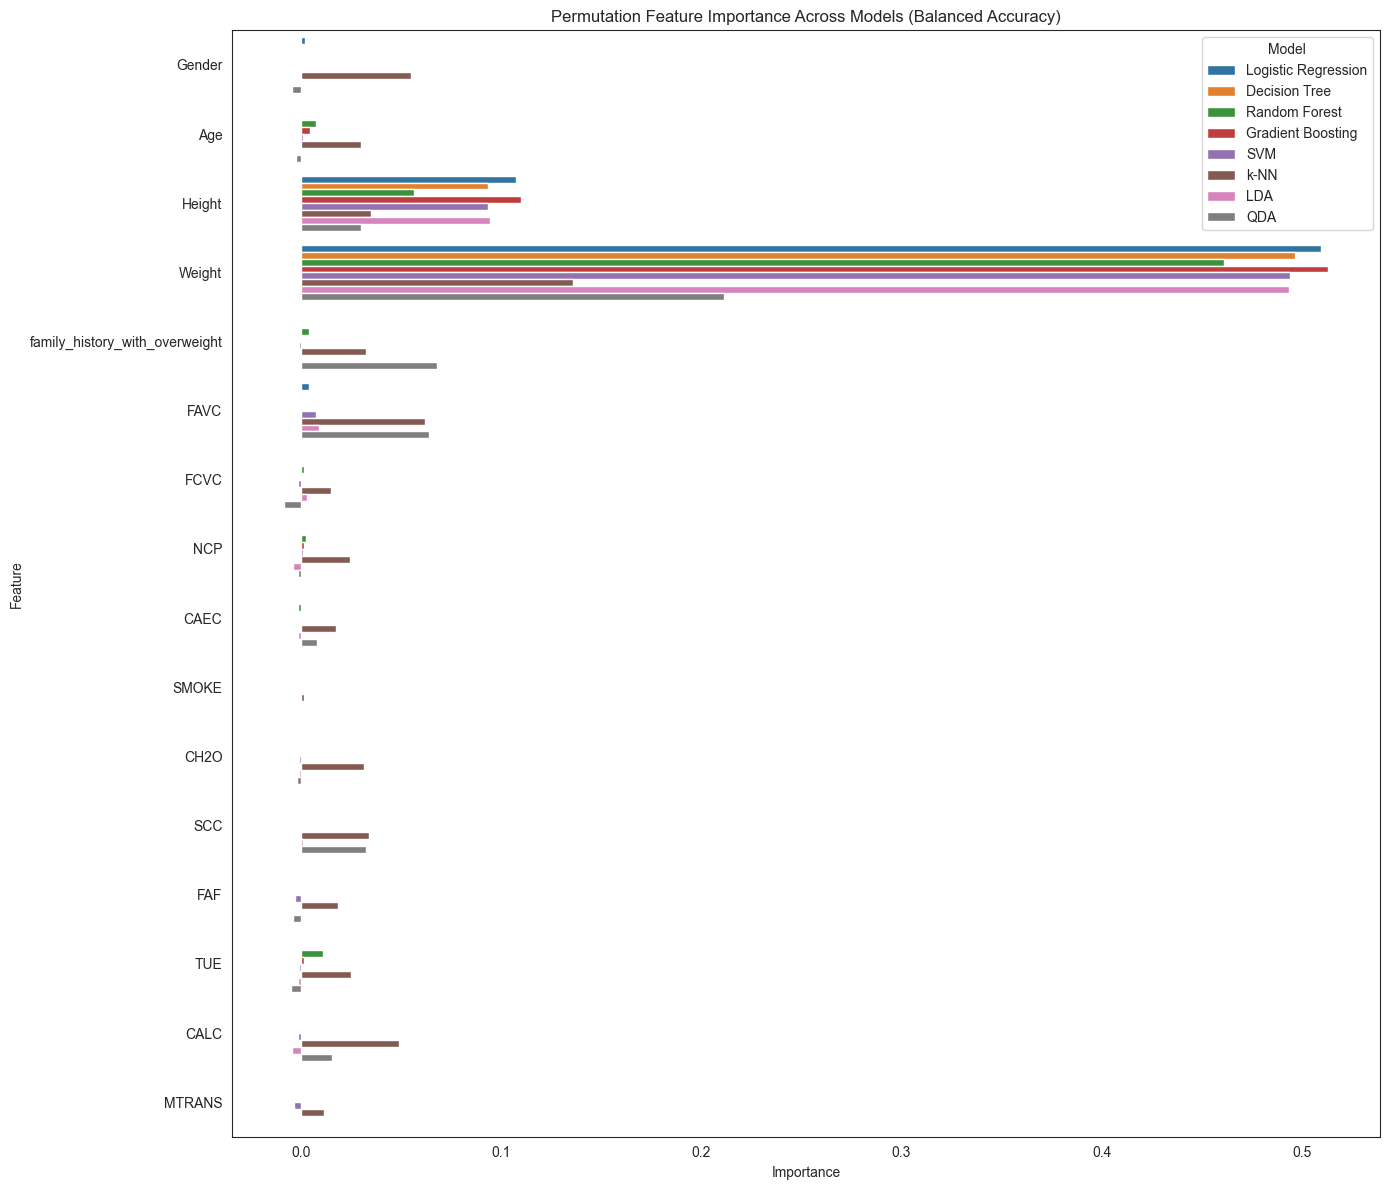

In [20]:
feature_names = X_test.columns

def get_permutation_importance(model, X, y, feature_names, model_name):
    result = permutation_importance(
        model, X, y,
        n_repeats=30,
        random_state=seed,
        scoring='balanced_accuracy'
    )
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean,
        'Model': model_name
    })

knn_pi  = get_permutation_importance(knn_model, X_test_scaled, y_test, feature_names, 'k-NN')
lda_pi  = get_permutation_importance(lda_model, X_test_scaled, y_test, feature_names, 'LDA')
qda_pi  = get_permutation_importance(qda_model, X_test_scaled, y_test, feature_names, 'QDA')
log_pi = get_permutation_importance(log_model, X_test_scaled, y_test, feature_names, 'Logistic Regression')
tree_pi = get_permutation_importance(tree_model, X_test, y_test, feature_names, 'Decision Tree')
rf_pi   = get_permutation_importance(rf_model, X_test, y_test, feature_names, 'Random Forest')
gb_pi   = get_permutation_importance(gb_model, X_test, y_test, feature_names, 'Gradient Boosting')
svm_pi  = get_permutation_importance(svm_model, X_test_scaled, y_test, feature_names, 'SVM')

all_importance = pd.concat([
    log_pi, tree_pi, rf_pi, gb_pi, svm_pi,
    knn_pi, lda_pi, qda_pi
])

plt.figure(figsize=(14, 12))
sns.barplot(data=all_importance, x='Importance', y='Feature', hue='Model')
plt.title("Permutation Feature Importance Across Models (Balanced Accuracy)")
plt.tight_layout()
plt.savefig("Feature_Importance")
plt.show()
